# Cancer Patient Survival Prediction using Neural Networks

This notebook implements a feedforward neural network to predict patient survival status based on clinical features from the China Cancer Patient Records dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

Matplotlib is building the font cache; this may take a moment.


Matplotlib is building the font cache; this may take a moment.


TensorFlow version: 2.19.0
GPU available: []


In [2]:
# Load the dataset
data_path = "/Users/f/.cache/kagglehub/datasets/ak0212/china-cancer-patient-records/versions/1/china_cancer_patients_synthetic.csv"
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['SurvivalStatus'].value_counts()}")
print(f"Target distribution (%):\n{df['SurvivalStatus'].value_counts(normalize=True) * 100}")

Dataset shape: (10000, 20)
Target distribution:
SurvivalStatus
Alive       7790
Deceased    2210
Name: count, dtype: int64
Target distribution (%):
SurvivalStatus
Alive       77.9
Deceased    22.1
Name: proportion, dtype: float64


## Data Preprocessing

In [3]:
# Create a copy for preprocessing
data = df.copy()

# Check missing values
print("Missing values per column:")
print(data.isnull().sum())
print("\nMissing values percentage:")
print((data.isnull().sum() / len(data)) * 100)

Missing values per column:
PatientID                  0
Gender                     0
Age                        0
Province                   0
Ethnicity                  0
TumorType                  0
CancerStage                0
DiagnosisDate              0
TumorSize                  0
Metastasis                 0
TreatmentType              0
SurgeryDate             5673
ChemotherapySessions       0
RadiationSessions          0
SurvivalStatus             0
FollowUpMonths             0
SmokingStatus              0
AlcoholUse              5921
GeneticMutation         7200
Comorbidities           3715
dtype: int64

Missing values percentage:
PatientID                0.00
Gender                   0.00
Age                      0.00
Province                 0.00
Ethnicity                0.00
TumorType                0.00
CancerStage              0.00
DiagnosisDate            0.00
TumorSize                0.00
Metastasis               0.00
TreatmentType            0.00
SurgeryDate           

In [4]:
# Select features for the model (excluding ID, dates, and target)
feature_columns = ['Gender', 'Age', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 
                  'TumorSize', 'Metastasis', 'TreatmentType', 'ChemotherapySessions', 
                  'RadiationSessions', 'FollowUpMonths', 'SmokingStatus', 'AlcoholUse', 
                  'GeneticMutation', 'Comorbidities']

# Create feature dataframe
X = data[feature_columns].copy()
y = data['SurvivalStatus'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (10000, 16)
Target vector shape: (10000,)


In [5]:
# Handle missing values and encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
label_encoders = {}

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# Handle categorical features
categorical_features = ['Gender', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 
                       'Metastasis', 'TreatmentType', 'SmokingStatus', 'AlcoholUse', 
                       'GeneticMutation', 'Comorbidities']

X_processed = X.copy()

for col in categorical_features:
    # Fill missing values with 'Unknown'
    X_processed[col] = X_processed[col].fillna('Unknown')
    
    # Label encode
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col])
    label_encoders[col] = le
    
    print(f"{col}: {len(le.classes_)} unique values")

# Handle numerical features
numerical_features = ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths']

for col in numerical_features:
    # Fill missing values with median
    X_processed[col] = X_processed[col].fillna(X_processed[col].median())

print(f"\nProcessed feature matrix shape: {X_processed.shape}")
print(f"Missing values after preprocessing: {X_processed.isnull().sum().sum()}")

Target encoding: {'Alive': np.int64(0), 'Deceased': np.int64(1)}
Gender: 3 unique values
Province: 13 unique values
Ethnicity: 6 unique values
TumorType: 6 unique values
CancerStage: 4 unique values
Metastasis: 2 unique values
TreatmentType: 5 unique values
SmokingStatus: 3 unique values
AlcoholUse: 3 unique values
GeneticMutation: 4 unique values
Comorbidities: 10 unique values

Processed feature matrix shape: (10000, 16)
Missing values after preprocessing: 0


## Train-Test Split and Feature Scaling

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature scaling completed")
print(f"Training data mean: {X_train_scaled.mean():.6f}")
print(f"Training data std: {X_train_scaled.std():.6f}")

Training set shape: (8000, 16)
Test set shape: (2000, 16)
Training target distribution: [6232 1768]
Test target distribution: [1558  442]
Feature scaling completed
Training data mean: -0.000000
Training data std: 1.000000


## Neural Network Model Definition

In [7]:
# Define the neural network architecture
def create_model(input_dim, hidden_layers=[128, 64, 32], dropout_rate=0.3, learning_rate=0.001):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(hidden_layers[0], activation='relu', input_dim=input_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer (binary classification)
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

# Create the model
input_dim = X_train_scaled.shape[1]
model = create_model(input_dim)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 12,993 (50.75 KB)

 Non-trainable params: 448 (1.75 KB)

## Model Training with Tracking

In [8]:
# Define callbacks for training monitoring
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Save best model
model_checkpoint = ModelCheckpoint(
    'best_survival_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [9]:
# Train the model with comprehensive tracking
print("Starting model training...")
start_time = time.time()

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed!")
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Number of epochs completed: {len(history.history['loss'])}")

Starting model training...
Epoch 1/100
179/200 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.6039 - loss: 0.7360 - precision: 0.3162 - recall: 0.6656 
Epoch 1: val_loss improved from inf to 0.46105, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6111 - loss: 0.7245 - precision: 0.3210 - recall: 0.6610 - val_accuracy: 0.7669 - val_loss: 0.4610 - val_precision: 0.4477 - val_recall: 0.4018 - learning_rate: 0.0010
Epoch 2/100
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.7629 - loss: 0.4696 - precision: 0.4737 - recall: 0.5280
Epoch 2: val_loss improved from 0.46105 to 0.37868, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.7629 - loss: 0.4695 - precision: 0.4737 - recall: 0.5276 - val_accuracy: 0.7675 - val_loss: 0.3787 - val_precision: 0.4563 - val_recall: 0.4751 - learning_rate: 0.0010
Epoch 3/100
145/200 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7814 - loss: 0.4126 - precision: 0.5153 - recall: 0.4574
Epoch 3: val_loss improved from 0.37868 to 0.35627, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.7823 - loss: 0.4092 - precision: 0.5157 - recall: 0.4582 - val_accuracy: 0.7725 - val_loss: 0.3563 - val_precision: 0.4648 - val_recall: 0.4457 - learning_rate: 0.0010
Epoch 4/100
 97/200 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.7908 - loss: 0.3799 - precision: 0.5440 - recall: 0.4317
Epoch 4: val_loss improved from 0.35627 to 0.34318, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.7868 - loss: 0.3802 - precision: 0.5325 - recall: 0.4430 - val_accuracy: 0.7750 - val_loss: 0.3432 - val_precision: 0.4678 - val_recall: 0.4047 - learning_rate: 0.0010
Epoch 5/100
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.7751 - loss: 0.3722 - precision: 0.4844 - recall: 0.3957
Epoch 5: val_loss improved from 0.34318 to 0.33297, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7752 - loss: 0.3722 - precision: 0.4846 - recall: 0.3960 - val_accuracy: 0.7725 - val_loss: 0.3330 - val_precision: 0.4657 - val_recall: 0.4575 - learning_rate: 0.0010
Epoch 6/100
 98/200 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.7808 - loss: 0.3584 - precision: 0.5396 - recall: 0.5094
Epoch 6: val_loss improved from 0.33297 to 0.32747, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7751 - loss: 0.3612 - precision: 0.5137 - recall: 0.4771 - val_accuracy: 0.7781 - val_loss: 0.3275 - val_precision: 0.4551 - val_recall: 0.2082 - learning_rate: 0.0010
Epoch 7/100
 99/200 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.7977 - loss: 0.3421 - precision: 0.5374 - recall: 0.3956
Epoch 7: val_loss improved from 0.32747 to 0.32199, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.7890 - loss: 0.3473 - precision: 0.5235 - recall: 0.4087 - val_accuracy: 0.7688 - val_loss: 0.3220 - val_precision: 0.4673 - val_recall: 0.6070 - learning_rate: 0.0010
Epoch 8/100
 98/200 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.7808 - loss: 0.3428 - precision: 0.4939 - recall: 0.4986
Epoch 8: val_loss improved from 0.32199 to 0.31853, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7812 - loss: 0.3440 - precision: 0.5013 - recall: 0.4907 - val_accuracy: 0.7619 - val_loss: 0.3185 - val_precision: 0.4429 - val_recall: 0.4545 - learning_rate: 0.0010
Epoch 9/100
152/200 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7879 - loss: 0.3257 - precision: 0.5111 - recall: 0.5059     
Epoch 9: val_loss improved from 0.31853 to 0.31680, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.7882 - loss: 0.3273 - precision: 0.5141 - recall: 0.5021 - val_accuracy: 0.7663 - val_loss: 0.3168 - val_precision: 0.4543 - val_recall: 0.4809 - learning_rate: 0.0010
Epoch 10/100
 99/200 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.7825 - loss: 0.3337 - precision: 0.5272 - recall: 0.5437
Epoch 10: val_loss improved from 0.31680 to 0.31501, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7831 - loss: 0.3343 - precision: 0.5190 - recall: 0.5099 - val_accuracy: 0.7706 - val_loss: 0.3150 - val_precision: 0.4472 - val_recall: 0.3226 - learning_rate: 0.0010
Epoch 11/100
 99/200 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.7899 - loss: 0.3307 - precision: 0.5438 - recall: 0.5328
Epoch 11: val_loss improved from 0.31501 to 0.31488, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7885 - loss: 0.3301 - precision: 0.5319 - recall: 0.5104 - val_accuracy: 0.7713 - val_loss: 0.3149 - val_precision: 0.4706 - val_recall: 0.5865 - learning_rate: 0.0010
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.7891 - loss: 0.3274 - precision: 0.5251 - recall: 0.5040
Epoch 12: val_loss improved from 0.31488 to 0.31391, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7891 - loss: 0.3274 - precision: 0.5250 - recall: 0.5039 - val_accuracy: 0.7706 - val_loss: 0.3139 - val_precision: 0.4454 - val_recall: 0.3109 - learning_rate: 0.0010
Epoch 13/100
 97/200 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.7961 - loss: 0.3137 - precision: 0.5202 - recall: 0.5174
Epoch 13: val_loss did not improve from 0.31391
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.7909 - loss: 0.3205 - precision: 0.5184 - recall: 0.4930 - val_accuracy: 0.7700 - val_loss: 0.3144 - val_precision: 0.4713 - val_recall: 0.6510 - learning_rate: 0.0010
Epoch 14/100
101/200 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.7806 - loss: 0.3272 - precision: 0.5240 - recall: 0.5004
Epoch 14: val_loss improved from 0.31391 to 0.31314, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.7804 - loss: 0.3280 - precision: 0.5147 - recall: 0.4907 - val_accuracy: 0.7681 - val_loss: 0.3131 - val_precision: 0.4599 - val_recall: 0.5044 - learning_rate: 0.0010
Epoch 15/100
101/200 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.7874 - loss: 0.3255 - precision: 0.5041 - recall: 0.5101
Epoch 15: val_loss improved from 0.31314 to 0.31259, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.7900 - loss: 0.3247 - precision: 0.5198 - recall: 0.5127 - val_accuracy: 0.7738 - val_loss: 0.3126 - val_precision: 0.4704 - val_recall: 0.4897 - learning_rate: 0.0010
Epoch 16/100
181/200 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.7820 - loss: 0.3264 - precision: 0.5206 - recall: 0.5002
Epoch 16: val_loss did not improve from 0.31259
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7823 - loss: 0.3261 - precision: 0.5204 - recall: 0.4979 - val_accuracy: 0.7644 - val_loss: 0.3129 - val_precision: 0.4437 - val_recall: 0.4164 - learning_rate: 0.0010
Epoch 17/100
101/200 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.8033 - loss: 0.3095 - precision: 0.5551 - recall: 0.5287
Epoch 17: val_loss did not improve from 0.31259
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.7993 - loss: 0.3130 - precision: 0.5449 - recall: 0.5059 - val_accuracy: 0.7681 - val_loss: 0.3128 - val_precision: 0.4667 - val_recall: 0.6158

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7831 - loss: 0.3222 - precision: 0.5107 - recall: 0.4676 - val_accuracy: 0.7713 - val_loss: 0.3119 - val_precision: 0.4691 - val_recall: 0.5572 - learning_rate: 0.0010
Epoch 20/100
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.7873 - loss: 0.3225 - precision: 0.5188 - recall: 0.5392
Epoch 20: val_loss improved from 0.31188 to 0.31085, saving model to best_survival_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7873 - loss: 0.3225 - precision: 0.5188 - recall: 0.5387 - val_accuracy: 0.7681 - val_loss: 0.3109 - val_precision: 0.4623 - val_recall: 0.5396 - learning_rate: 0.0010
Epoch 21/100
 99/200 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.7732 - loss: 0.3341 - precision: 0.5203 - recall: 0.5452
Epoch 21: val_loss did not improve from 0.31085
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.7818 - loss: 0.3263 - precision: 0.5301 - recall: 0.5518 - val_accuracy: 0.7869 - val_loss: 0.3137 - val_precision: 0.5000 - val_recall: 0.1877 - learning_rate: 0.0010
Epoch 22/100
102/200 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.7787 - loss: 0.3272 - precision: 0.5286 - recall: 0.4314
Epoch 22: val_loss did not improve from 0.31085
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.7799 - loss: 0.3258 - precision: 0.5201 - recall: 0.4422 - val_accuracy: 0.7719 - val_loss: 0.3115 - val_precision: 0.4600 - val_recall: 0.4047

## Training Progress Visualization

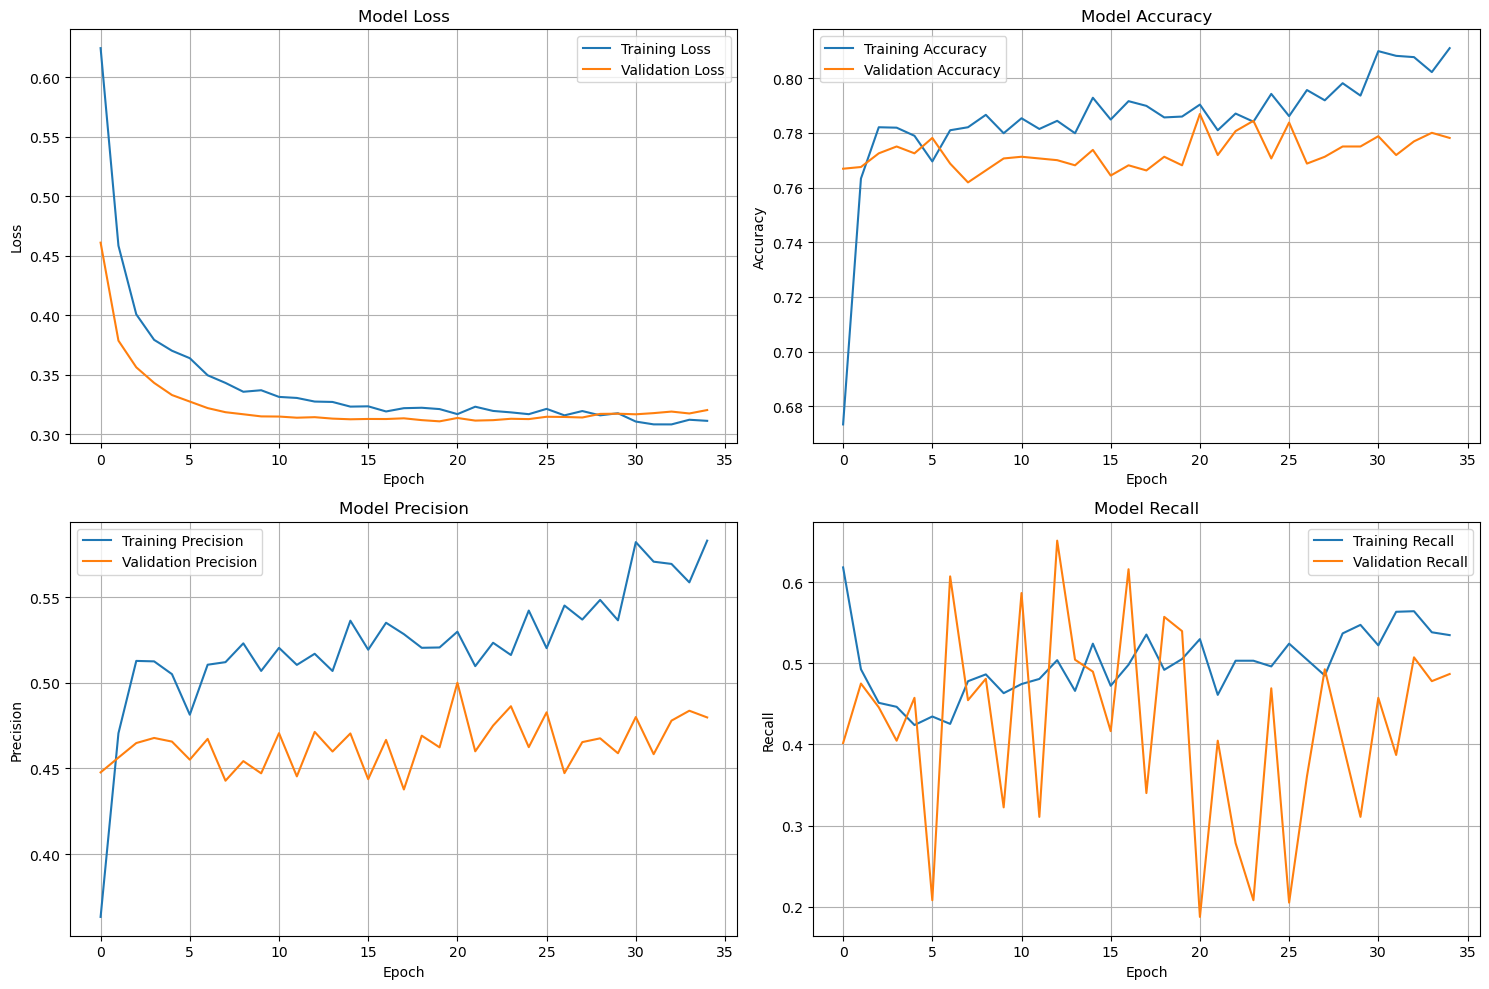

In [10]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Model Evaluation

In [11]:
# Make predictions
print("Evaluating model on test set...")
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test_scaled, y_test, verbose=0)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\n=== Model Performance ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"AUC Score: {auc_score:.4f}")

# Classification report
print(f"\n=== Classification Report ===")
target_names = ['Deceased', 'Alive']
print(classification_report(y_test, y_pred, target_names=target_names))

Evaluating model on test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step

=== Model Performance ===
Test Loss: 0.3150
Test Accuracy: 0.7650
Test Precision: 0.4698
Test Recall: 0.4932
AUC Score: 0.8474

=== Classification Report ===
              precision    recall  f1-score   support

    Deceased       0.85      0.84      0.85      1558
       Alive       0.47      0.49      0.48       442

    accuracy                           0.77      2000
   macro avg       0.66      0.67      0.66      2000
weighted avg       0.77      0.77      0.77      2000



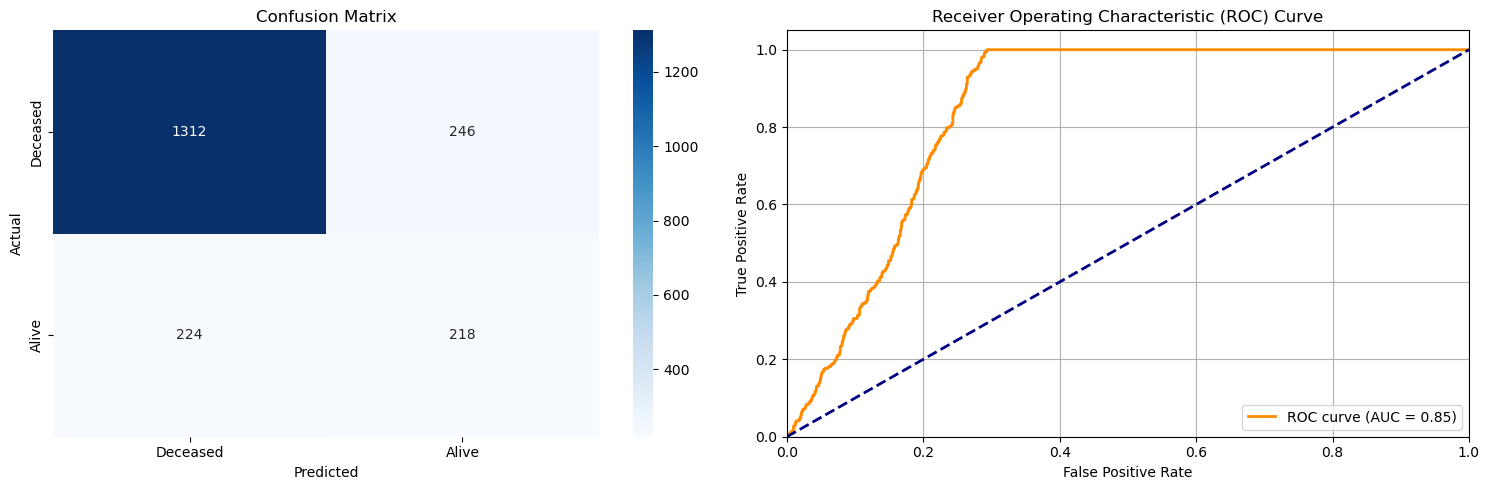

In [12]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Deceased', 'Alive'])
axes[0].set_yticklabels(['Deceased', 'Alive'])

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Training Summary

In [13]:
# Final training summary
print("=== TRAINING SUMMARY ===")
print(f"Dataset size: {len(df):,} patients")
print(f"Training set: {len(X_train):,} patients")
print(f"Test set: {len(X_test):,} patients")
print(f"Number of features: {input_dim}")
print(f"Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Epochs completed: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final test accuracy: {test_accuracy:.4f}")
print(f"Final AUC score: {auc_score:.4f}")

# Model architecture summary
print(f"\n=== MODEL ARCHITECTURE ===")
total_params = model.count_params()
print(f"Total parameters: {total_params:,}")
print(f"Model layers: {len(model.layers)}")

=== TRAINING SUMMARY ===
Dataset size: 10,000 patients
Training set: 8,000 patients
Test set: 2,000 patients
Number of features: 16
Training time: 5.84 seconds (0.10 minutes)
Epochs completed: 35
Best validation loss: 0.3109
Best validation accuracy: 0.7869
Final test accuracy: 0.7650
Final AUC score: 0.8474

=== MODEL ARCHITECTURE ===
Total parameters: 13,441
Model layers: 10


## Understanding Class Imbalance Solutions

### Problem: Your dataset has severe class imbalance
- **Deceased patients**: 78% (majority class)
- **Alive patients**: 22% (minority class)

This causes the model to be biased toward predicting "Deceased" to maximize overall accuracy, resulting in poor performance on the minority "Alive" class.

### Two Key Solutions:
1. **Class Weighting**: Penalize wrong predictions on minority class more heavily
2. **Threshold Tuning**: Adjust the decision boundary from default 0.5

## 1. Class Weighting Explained

**What it does**: Assigns different penalty weights to each class during training.

**How it works**:
- Majority class (Deceased): Lower weight = smaller penalty for misclassification
- Minority class (Alive): Higher weight = larger penalty for misclassification
- Forces model to pay more attention to minority class

**Mathematical concept**:
```
Weight = n_samples / (n_classes * n_samples_for_class)

For your data:
- Deceased weight = 10000 / (2 * 7800) ≈ 0.64
- Alive weight = 10000 / (2 * 2200) ≈ 2.27
```

This means misclassifying an "Alive" patient costs 2.27x more than misclassifying a "Deceased" patient.

In [ ]:
# Demonstrate class weighting calculation
from sklearn.utils.class_weight import compute_class_weight

print("=== CLASS WEIGHTING ANALYSIS ===")
print(f"Original class distribution:")
print(f"Deceased (class 1): {np.sum(y_train == 1):,} samples ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"Alive (class 0): {np.sum(y_train == 0):,} samples ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")

# Calculate balanced class weights
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\nCalculated class weights:")
print(f"Alive (class 0): {class_weights[0]:.3f}")
print(f"Deceased (class 1): {class_weights[1]:.3f}")
print(f"Ratio (Alive/Deceased): {class_weights[0]/class_weights[1]:.2f}x")

print(f"\nWhat this means:")
print(f"- Misclassifying an 'Alive' patient costs {class_weights[0]/class_weights[1]:.2f}x more")
print(f"- Model will be more careful about predicting 'Deceased' for actual 'Alive' patients")

In [ ]:
# Train a new model with class weighting
print("Training model with class weighting...")

# Create model with same architecture
model_weighted = create_model(input_dim)

# Train with class weights
history_weighted = model_weighted.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,  # Fewer epochs for demo
    batch_size=32,
    class_weight=class_weight_dict,  # This is the key addition
    callbacks=[early_stopping],
    verbose=0
)

print("Training completed!")

In [ ]:
# Compare original vs weighted model performance
print("=== MODEL COMPARISON: Original vs Class Weighted ===")

# Original model predictions (already calculated)
y_pred_original = y_pred
y_pred_proba_original = y_pred_proba

# Weighted model predictions
y_pred_proba_weighted = model_weighted.predict(X_test_scaled, verbose=0)
y_pred_weighted = (y_pred_proba_weighted > 0.5).astype(int).flatten()

# Classification reports
from sklearn.metrics import classification_report

print("ORIGINAL MODEL:")
print(classification_report(y_test, y_pred_original, target_names=target_names))

print("\nCLASS WEIGHTED MODEL:")
print(classification_report(y_test, y_pred_weighted, target_names=target_names))

# Focus on minority class improvement
original_alive_recall = classification_report(y_test, y_pred_original, target_names=target_names, output_dict=True)['Alive']['recall']
weighted_alive_recall = classification_report(y_test, y_pred_weighted, target_names=target_names, output_dict=True)['Alive']['recall']

print(f"\n=== MINORITY CLASS (ALIVE) IMPROVEMENT ===")
print(f"Original model - Alive recall: {original_alive_recall:.3f}")
print(f"Weighted model - Alive recall: {weighted_alive_recall:.3f}")
print(f"Improvement: {weighted_alive_recall - original_alive_recall:.3f} ({(weighted_alive_recall/original_alive_recall - 1)*100:.1f}% increase)")

## 2. Threshold Tuning Explained

**The Problem with Default 0.5 Threshold**:
- Binary classification uses 0.5 as decision boundary by default
- If `predicted_probability > 0.5` → predict positive class
- With imbalanced data, this favors the majority class

**Threshold Tuning Process**:
1. Use model to get prediction probabilities (0.0 to 1.0)
2. Try different thresholds (0.1, 0.2, 0.3, ..., 0.9)
3. For each threshold, calculate metrics (precision, recall, F1)
4. Choose threshold that optimizes your preferred metric

**For medical data**: Often want to maximize **recall** for the positive class (finding all true cases)

In [ ]:
# Threshold tuning demonstration
from sklearn.metrics import precision_recall_curve, f1_score

print("=== THRESHOLD TUNING ANALYSIS ===")

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_weighted.flatten())

# Calculate F1 scores for each threshold
f1_scores = []
thresholds_extended = np.append(thresholds, 1.0)  # Add final threshold

for thresh in thresholds_extended:
    y_pred_thresh = (y_pred_proba_weighted.flatten() >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_extended[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Default threshold (0.5): F1 = {f1_score(y_test, y_pred_weighted):.3f}")
print(f"Optimal threshold ({optimal_threshold:.3f}): F1 = {optimal_f1:.3f}")
print(f"Improvement: {optimal_f1 - f1_score(y_test, y_pred_weighted):.3f}")

# Test a range of common thresholds
test_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"\n=== THRESHOLD COMPARISON ===")
print("Threshold | Precision | Recall | F1-Score | Alive Recall")
print("-" * 55)

for thresh in test_thresholds:
    y_pred_thresh = (y_pred_proba_weighted.flatten() >= thresh).astype(int)
    report = classification_report(y_test, y_pred_thresh, target_names=target_names, output_dict=True)
    
    precision_avg = report['weighted avg']['precision']
    recall_avg = report['weighted avg']['recall']
    f1_avg = report['weighted avg']['f1-score']
    alive_recall = report['Alive']['recall']
    
    print(f"  {thresh:.1f}     |   {precision_avg:.3f}   |  {recall_avg:.3f}  |  {f1_avg:.3f}   |   {alive_recall:.3f}")

In [ ]:
# Visualize threshold tuning impact
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Precision-Recall Curve
axes[0].plot(recall, precision, 'b-', linewidth=2)
axes[0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random Classifier')
axes[0].scatter(recall[optimal_idx], precision[optimal_idx], color='red', s=100, zorder=5, label=f'Optimal Threshold ({optimal_threshold:.3f})')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True)

# Plot 2: F1 Score vs Threshold
axes[1].plot(thresholds_extended, f1_scores, 'g-', linewidth=2)
axes[1].axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='Default Threshold')
axes[1].axvline(x=optimal_threshold, color='orange', linestyle='--', alpha=0.7, label=f'Optimal Threshold ({optimal_threshold:.3f})')
axes[1].scatter(optimal_threshold, optimal_f1, color='red', s=100, zorder=5)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score vs Threshold')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Confusion Matrix at Optimal Threshold
y_pred_optimal = (y_pred_proba_weighted.flatten() >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticklabels(['Deceased', 'Alive'])
axes[2].set_yticklabels(['Deceased', 'Alive'])

plt.tight_layout()
plt.show()

## Key Takeaways

### Class Weighting:
- **Best for**: Training phase improvement
- **Impact**: Forces model to learn minority class patterns better
- **Trade-off**: May slightly reduce overall accuracy but improves minority class performance
- **When to use**: Always recommended for imbalanced datasets

### Threshold Tuning:
- **Best for**: Post-training optimization
- **Impact**: Optimizes decision boundary for your specific metric
- **Trade-off**: Precision vs Recall balance
- **When to use**: When you have specific business requirements (e.g., medical: minimize false negatives)

### For Your Cancer Survival Data:
1. **Class weighting** helps the model learn "Alive" patterns better during training
2. **Threshold tuning** optimizes predictions for medical context (catching all potential survivors)
3. **Combined approach** often yields best results: train with class weights, then tune threshold

### Medical Context Considerations:
- **False Negative (predicting Deceased when Alive)**: Very serious - might miss treatment opportunities
- **False Positive (predicting Alive when Deceased)**: Less critical - extra monitoring won't harm
- Therefore: Lower threshold (0.3-0.4) might be preferable to catch more "Alive" cases